In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import sklearn as skl

# Causality
## Associational models versus causal models

Causal models differ from associational models in that they codify causal directions not just associations.  In our program, you might have learned of the use of propensity scores, counterfactuals or randomization to study causality. There, typically the goal is to make causal statements with as few assumptions as possible or at least understanding the assumptions. Typically, the object of study is the estimation of an effect avergated over covarites.

Causal graphs take a different approach, even if they wind up at the same place. Here, the goal is to postulate hyptothetical causal relationships and use those hypothetical relationships to estimate causal effects.

### Graphs and graphical models
A graph, $G$ is a collection of nodes, say $V=\{1,\ldots, p\}$ and a set edges between the nodes, i.e. a set of elements $(i,j)$. The graph is directed if $(i,j)$ is considered different then $(j,i)$.


Node $i$ is a parent of node $j$ if $(i,j) \in E$ and $(j,i)\notin E$. Similarly,  node $i$ is a **child** of node $j$ if $(j,i) \in E$ and $(i,j)\notin E$. A node
is a **descendant** of another if it is a child, or a child of a child and so on.


### DAG and SCMs

DAGs define a unique factorization (set of independence relationships) with compatible probability models.  I find it useful to think of causal DAGs in the terms of structural causal models (SCMs). Such models demonstrate an example of a generative models that statisfy the DAG and the have clear connections with the probabability models. An SCM over a collection of variables, $X=(X_1, \ldots, X_p)$, postulates a set of functional relationships
$$
X_j = f(P_j, \epsilon_j)
$$
where $P_j$ are the antecedent causes of $X_j$, called the parents of $X_j$, and $\epsilon_j$ is an accumulation of variables treated as mutally independent. This defines a directed graph, $G$ say, where a graph is collection of vertices corresponding to our variables, $V=\{1,\ldots, p\}$, corresponding to the $X_i$, and edges, $E$, which is a set of ordered pairs of nodes.

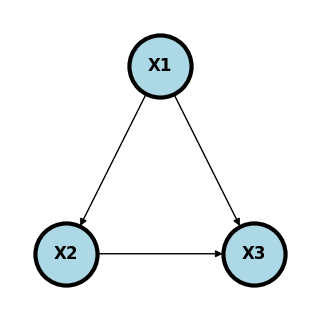

In [2]:
plt.figure(figsize=[3, 3])
G = nx.DiGraph()
G.add_node("X1",  pos = (0.5,   1) )
G.add_node("X2",  pos = (0  ,   0) )
G.add_node("X3",  pos =  (1 ,   0) )
G.add_edges_from([
  ["X1", "X2"],
  ["X1", "X3"],
  ["X2", "X3"],
] )

nx.draw(G,
        nx.get_node_attributes(G, 'pos'),
        with_labels=True,
        font_weight='bold',
        node_size = 2000,
        node_color = "lightblue",
        linewidths = 3)
ax= plt.gca()
ax.collections[0].set_edgecolor("#000000")
ax.set_xlim([-.3, 1.3])
ax.set_ylim([-.3, 1.3])
plt.show()

In this case, $P_1 = \{\}$, $P_2 = \{1\}$ and $P_3 = \{1,2\}$. DAGs in general define the independence assumptions associated with compatible probability models. SCMs are such an example that clearly define compatible probability models.   Of course, given a large enough cross-sectional sample, we can estimate the joint distribution of $P(X_1,\ldots, X_p)$ and all of its conditionals. Disregarding statistical variation, which can be accounted for using traditional inferential methods, these conditionals should agree with the independence relationships from the DAG, if the DAG is correct. This yields a fruitful way to consider probability models. For example one could use DAGs as a heuristic and see how the observed data agrees with the independence relationships in compatible probability models implied by the DAG.

By itself, this does not create any causal claims. However, the following strategy could. Postulate a causal model, like the SCM, consider the independence relationships implied by the SCM, compares those indepnence relationships with those seen in the observed data. This gives us a method to falsify causal models using the data.  

One specific way in which we use the assumptions is to investigate how the graph changes when we fix a node at a specific value, like an intevention, thus breaking its association with its parents. This operation is conceptual, but at times we can relate probabilities associated with interventions that were not realized. Consider an instrance where  where $X_1$ is a collection of confounders, $X_2$ is an exposure and $X_3$ is an outcome. Ideally, we'd like to know
$$
P(X_3 ~|~ do(X_2) = x_2)
$$
That is, the impact on the response if we were to set the exposure to $e_0$.

### Blocking and d-separation

Before we talk about interventions, let's consider discussing compatibility of the hypothetical directed graph and our observed data. Return to our previous diagram.

+ $X1$ is a *confounder* betweend $X2$ and $X3$
+ $X2$ is a *mediator* between $X1$ and $X3$
+ $X3$ is a *collider* between $X1$ and $X2$

Consider an example. $X1$ is having a BMI > 35, $X2$ is sleep disordered breathing and $X3$ is hypertension.

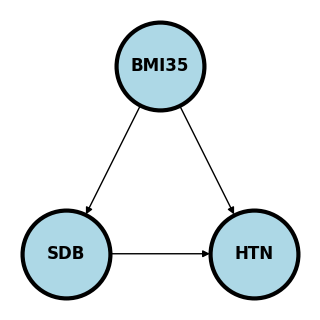

In [3]:
plt.figure(figsize=[3, 3])
G = nx.DiGraph()
G.add_node("BMI35",  pos = (0.5,   1) )
G.add_node("SDB",  pos = (0  ,   0) )
G.add_node("HTN",  pos =  (1 ,   0) )
G.add_edges_from([
  ["BMI35", "SDB"],
  ["BMI35", "HTN"],
  ["SDB", "HTN"],
] )

nx.draw(G,
        nx.get_node_attributes(G, 'pos'),
        with_labels=True,
        font_weight='bold',
        node_size = 4000,
        node_color = "lightblue",
        linewidths = 3)
ax= plt.gca()
ax.collections[0].set_edgecolor("#000000")
ax.set_xlim([-.3, 1.3])
ax.set_ylim([-.3, 1.3])
plt.show()

Here if we're studying whether SDB causes HTN, BMI35 confounds the relationship as a possible common cause of both.  We would need to adjust for BMI35 to make sure the association between SDB and HTN isn't just due to this common cause.

If we were studying whether BMI35 causes HTN, we might be interested in how much of that effect is mediated (indirectly) through  SDB and how much is directly from BMI35.

If we are studying the relationship between BMI35 and SDB directly, adjusting for HTN may cause an association. Consider the (fictitious) case where there is a large number of people who have SDB who are not obese, yet all have hypertension, for whatever the reason. Then, among the HTN, there could be a negative association between BMI35 and SDB, because of the large collection of patients would who have SDB and are not obese and the same for obese and not hyptertensive. That is, adjusting for HTN created an association. This is an example of [Berkson's paradox](https://en.wikipedia.org/wiki/Berkson%27s_paradox). This is a somewhat contrived example, but hopefully you get the point.
The wikipedia article has a funny example where they consider $X_1$ is whether or not the hamburger is good at a fast food restaurant, $X_2$ is whether or not the fries are good and $X_3$ is whether or not people eat there. Since few people would eat at a place where both the hamburger and fries are bad, conditioning on $X_3$ can create a negative association.

The main point here is that adjusting for colliders may open up a pathway between the nodes.

A **path** between two nodes $n_1$ and $n_k$ is a sequence of nodes, $v_1, v_2,\ldots v_{k}$, where  $v_{i}$ and $v_{i+1}$ are connected. The path is **directed** if $v_{i}$ points to $v_{i+1}$ for $i=1,\ldots,k$. A graph is a Directed Acyclic Graph (DAG) if all edges are directed and there are no two nodes $v_i$ and $v_j$ with a directed path in both directions.  

A path between $v_1$ and $v_k$, $v_1,\ldots, v_k$, is blocked by a set of nodes, $S$, if for some $v_j$ in $S$

1. $v_j\in S$ and $v_k$ is a mediator or confounder between $v_{j-1}$ and $v_{j+1}$ in either direction **or**
2. $v_j\notin S$ and all of the descendants of $v_j \notin S$ and $v_{j}$ is a collider between $v_{j-1}$ and $v_{j+1}$.

In other words, a path is **blocked** if a mediator or confounder is included in $S$ or a collider and all of its descendants is excluded from $S$.

For 1. this is equivalent to saying one of

* $v_{j-1}\rightarrow v_{j} \rightarrow v_{j+1}$
* $v_{j-1}\leftarrow v_{j} \leftarrow v_{j+1}$
* $v_{j-1}\leftarrow v_{j} \rightarrow v_{j+1}$

holds. For 2. recall a collider is $v_{j-1}\rightarrow v_{j} \leftarrow v_{j+1}$.

This could be translated into the following statistical statement. Conditioning on a mediator or confounder or **not** conditioning on a collider blocks a path, conditioning on a collider opens a path.

We say that two nodes or groups of nodes are **d-separated** by a set of nodes, $S$, if every path between nodes in the two groups is blocked by $S$. d-separation is useful because it gives us conditional independence relationships in the sense that if $X_i$ is d-separated with $X_j$ given $S$ then $X_i \perp X_j ~|~ S$ on all probability distribution compatible with the graph.


Consider the following graph.

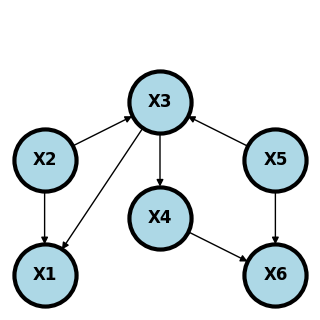

In [4]:
plt.figure(figsize=[3, 3])
G = nx.DiGraph()
G.add_node("X1",  pos = (0,   0) )
G.add_node("X2", pos = (0,   1) )
G.add_node("X3", pos = (1, 1.5) )
G.add_node("X4", pos = (1,  .5) )
G.add_node("X5", pos = (2,   1) )
G.add_node("X6",  pos = (2,   0) )
G.add_edges_from([
  ["X2", "X1" ],
  ["X2", "X3"],
  ["X3", "X1" ],
  ["X3", "X4"],
  ["X4", "X6" ],
  ["X5", "X3"],
  ["X5", "X6" ]
] )

nx.draw(G,
        nx.get_node_attributes(G, 'pos'),
        with_labels=True,
        font_weight='bold',
        node_size = 2000,
        node_color = "lightblue",
        linewidths = 3)
ax= plt.gca()
ax.collections[0].set_edgecolor("#000000")
ax.set_xlim([-.3, 2.3])
ax.set_ylim([-.3, 2.3])
plt.show()

$X_1$ and $X_5$ are conditionally indepndent given $X_2$ and $X_3$. Why? Conditioning on $X_2$ blocks the paths $X_1 \leftarrow X_2 \rightarrow X_3 \leftarrow X_5$ even despite the part $X_2 \rightarrow X_3 \leftarrow X_5$ is opened by conditioning on the collider, $X_3$. Furthermore, conditioning on $X_2$ or $X_3$ blocks the path $X_1 \leftarrow X_2 \rightarrow X_3 \rightarrow X_4 \rightarrow X_6 \leftarrow X_5$. Finally, conditioning on $X_3$ blocks the path $X_1 \leftarrow X_3 \leftarrow X_5$.

Another interesting one is that $X_2$ and $X_5$ are marginally independent. This is because **not** conditioining on $X_3$ blocks the path $X_2 \rightarrow X_3 \leftarrow X_5$ and **not** conditioning on $X_6$ blocks the path $X_2 \rightarrow X_3 \rightarrow X_4 \rightarrow X_6 \leftarrow X_5$.

Here's the complete set of conditional independence relationships.

1. $X_1$ and $X_4$ are d-separated by $\{X_3\}$
2. $X_1$ and $X_5$ are d-separated by $\{X_2, X_3\}$
3. $X_1$ and $X_6$ are d-separated by $\{X_4, X_5\}$, $\{X_3, X_5\}$, $\{X_2, X_3\}$
4. $X_2$ and $X_4$ are d-separated by $\{X_3\}$
5. $X_2$ and $X_5$ are d-separated by $\{\}$ (the null set, i.e. they're marginally independent).
6. $X_2$ and $X_6$ are d-separated by $\{X_4, X_5\}$, $\{X_3, X_5\}$
7. $X_3$ and $X_6$ are d-separated by $\{X_4, X_5\}$
8. $X_4$ and $X_5$ are d-separated by $X_3$.

These all imply the independence relationships, such as
$X_1 \perp X_4 ~|~ X_3$.

## Do calculus and backdoor criterion

Recall that specifying a causal graph implies the independence relationships of a probability distribution under assumptions such as the SCM. Sometimes, we're interested in the causal relationship between an exposure, $X$ and an outcome, $Y$.  Consider a theoretical intervention obtained by setting $X = a$, which we write as $do(X) = a$. We want to estimate $P(Y ~|~ do(X) = a)$.

A set $Z$ satisfies the **back door** criterion with respect
to nodes $X$ and $Y$ if

1. No descendant of $X$ is in $Z$.
2. $Z$ blocks every path $X$ and $Y$ that contains an arrow pointing to $X$.

The back door criteria is similar to d-separation. However, we only focus on arrows pointing into $X$ and don't allow for descendants of $X$.

The magic of the back door adjustment comes from the relationship, the adjustment formula:

$$
P(Y ~|~ do(X) = x) = \sum_{z\in S} P(y ~ | x, z) p(z)
$$

where $S$ satisfies the back door criterion. If the $z$ are all observed variables, then the RHS of this equation is estimable. Note the interesting statement that not all variables need to be observed, just $y$, $x$ and $z$.




So, in our previous example, adjusting for $S = \{X_2, X_3\}$ allows us to estimate the causal effect of $X$ on $Y$, even if $X_4$ and $X_5$ are not measured.

It's important to emphasize, that every aspect of the adjustment formula is theoretically estimable if $Y$, $X$ and the nodes in $S$ are observed.  

Consider the following graph.

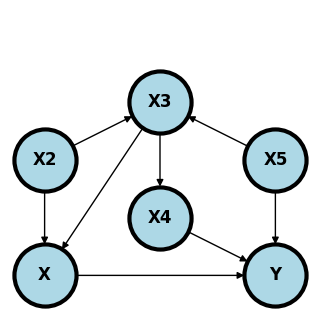

In [5]:
plt.figure(figsize=[3, 3])
G = nx.DiGraph()
G.add_node("X",  pos = (0,   0) )
G.add_node("Y",  pos = (2,   0) )
G.add_node("X2", pos = (0,   1) )
G.add_node("X3", pos = (1, 1.5) )
G.add_node("X4", pos = (1,  .5) )
G.add_node("X5", pos = (2,   1) )
G.add_edges_from([
  ["X", "Y"  ],
  ["X2", "X" ],
  ["X2", "X3"],
  ["X3", "X" ],
  ["X3", "X4"],
  ["X4", "Y" ],
  ["X5", "X3"],
  ["X5", "Y" ]
] )

nx.draw(G,
        nx.get_node_attributes(G, 'pos'),
        with_labels=True,
        font_weight='bold',
        node_size = 2000,
        node_color = "lightblue",
        linewidths = 3)
ax= plt.gca()
ax.collections[0].set_edgecolor("#000000")
ax.set_xlim([-.3, 2.3])
ax.set_ylim([-.3, 2.3])
plt.show()

Here are the minimal backdoor adjustment variables between $X$ and $Y$:

1. $S = \{X_2, X_3\}$
2. $S = \{X_3, X_5\}$
3. $S = \{X_4, X_5\}$

Here are some **invalid** backdoor sets of variables.

1. $S$ equal to any single node.
   1. $S=\{X_3\}$ does not block the path $X\leftarrow X_2 \rightarrow X_3 \leftarrow X_5 \rightarrow Y$.
   2. $S=\{X_4\}$ or $S=\{X_2\}$ does not block the path $X \leftarrow X_3 \leftarrow X_5 \rightarrow Y$.
   3. $S=\{X_5\}$ does not block the path $X \leftarrow X_3 \leftarrow X_4 \rightarrow Y$.
2. $S=\{X_3, X_4\}$ does not block the path
$X \leftarrow X_2 \rightarrow X_3 \leftarrow X_5 \rightarrow Y$.
3. $S=\{X_2, X_4\}$ does not block the path $X\leftarrow X_3 \leftarrow X_5 \rightarrow Y$.


### Example graphs

In all the following, we're interested in the causal effect of $X$ and $Y$. $Z$ variables are observed and $U$ variables
are unobserved. Every variable is binary to make the discussion easier.

#### Randomization

If $X$ is randomized **and everyone takes the treatment assigned to them** (left plot) then $X$ has no parents other than the randomization mechanism,$R$.  We're omitting any descendants of $X$ since we don't have to worray about them. Regardless of the complexity of  the relationship between the collection of observed, unobserved, known and unknown variables, $Z, U$, and $Y$
we can estimate the causal effect simply without conditioning on anything.

In contrast, if some people ignore their randomized treatment status and elect to choose a different treatment one may have opened a backdoor path (right plot). For example, if the treatment can't be blinded and those randomized to the control with the worst baseline symptoms elect to obtain the treatment elsewhere.

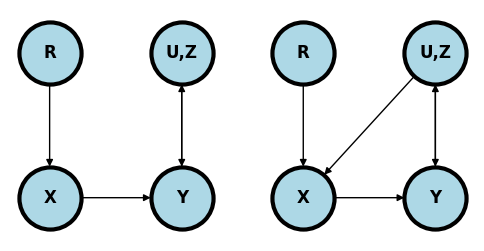

In [6]:
plt.figure(figsize=[6, 3])

plt.subplot(1, 2, 1)
G = nx.DiGraph()
G.add_node("X",  pos = (0  ,   0) )
G.add_node("R",  pos = (0  ,   1) )
G.add_node("U,Z",  pos = (1,   1) )
G.add_node("Y",  pos =  (1 ,   0) )
G.add_edges_from([
  ["R", "X"],
  ["X", "Y"],
  ["U,Z", "Y"],
  ["Y", "U,Z"]
] )
nx.draw(G,
        nx.get_node_attributes(G, 'pos'),
        with_labels=True,
        font_weight='bold',
        node_size = 2000,
        node_color = "lightblue",
        linewidths = 3)
ax= plt.gca()
ax.collections[0].set_edgecolor("#000000")
ax.set_xlim([-.3, 1.3])
ax.set_ylim([-.3, 1.3])




plt.subplot(1, 2, 2)

G = nx.DiGraph()
G.add_node("X",  pos = (0  ,   0) )
G.add_node("R",  pos = (0  ,   1) )
G.add_node("U,Z",  pos = (1,   1) )
G.add_node("Y",  pos =  (1 ,   0) )
G.add_edges_from([
  ["R", "X"],
  ["X", "Y"],
  ["U,Z", "Y"],
  ["U,Z", "X"],
  ["Y", "U,Z"]
] )
nx.draw(G,
        nx.get_node_attributes(G, 'pos'),
        with_labels=True,
        font_weight='bold',
        node_size = 2000,
        node_color = "lightblue",
        linewidths = 3)
ax= plt.gca()
ax.collections[0].set_edgecolor("#000000")
ax.set_xlim([-.3, 1.3])
ax.set_ylim([-.3, 1.3])



plt.show()

#### Simple confounding

The diagram below shows classic confounding. Conditioning in $Z$ allows for the estimation of the causal effect.

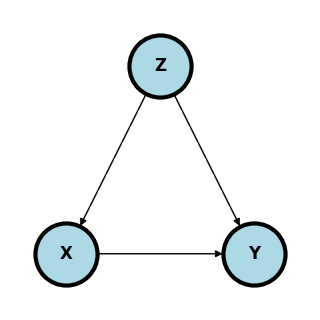

In [7]:
plt.figure(figsize=[3, 3])
G = nx.DiGraph()
G.add_node("X",  pos = (0  ,   0) )
G.add_node("Z",  pos = (0.5,   1) )
G.add_node("Y",  pos =  (1 ,   0) )
G.add_edges_from([
  ["X", "Y"],
  ["Z", "X"],
  ["Z", "Y"],
] )
nx.draw(G,
        nx.get_node_attributes(G, 'pos'),
        with_labels=True,
        font_weight='bold',
        node_size = 2000,
        node_color = "lightblue",
        linewidths = 3)
ax= plt.gca()
ax.collections[0].set_edgecolor("#000000")
ax.set_xlim([-.3, 1.3])
ax.set_ylim([-.3, 1.3])
plt.show()

Now the estimate of the adjusted effect (under our assumptions) is

$$
P(Y ~|~ do(X) = x) = P(Y ~|~ X=x, z = 0)P(z = 0) + P(Y ~|~ X=x, Z=1)P(Z=1)
$$


In the following two examples, the unmeasured confounder $U$ can be controlled for by conditioning on $Z$ and exactly the same estimate can be used as in the simple confounding model.

(-0.3, 1.3)

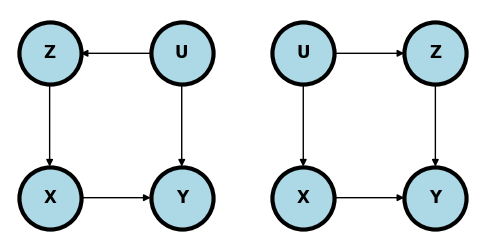

In [8]:
plt.figure(figsize=[6, 3])

plt.subplot(1, 2, 1)
G = nx.DiGraph()
G.add_node("X",  pos = (0,   0) )
G.add_node("Z",  pos = (0,   1) )
G.add_node("U",  pos = (1,   1) )

G.add_node("Y",  pos = (1 ,   0) )
G.add_edges_from([
  ["X", "Y"],
  ["U", "Z"],
  ["Z", "X"],
  ["U", "Y"],
] )
nx.draw(G,
        nx.get_node_attributes(G, 'pos'),
        with_labels=True,
        font_weight='bold',
        node_size = 2000,
        node_color = "lightblue",
        linewidths = 3)
ax= plt.gca()
ax.collections[0].set_edgecolor("#000000")
ax.set_xlim([-.3, 1.3])
ax.set_ylim([-.3, 1.3])


plt.subplot(1, 2, 2)
G = nx.DiGraph()
G.add_node("X",  pos = (0  ,   0) )
G.add_node("U",  pos = (0,   1) )
G.add_node("Z",  pos = (1,   1) )
G.add_node("Y",  pos =  (1 ,   0) )
G.add_edges_from([
  ["X", "Y"],
  ["U", "X"],
  ["U", "Z"],
  ["Z", "Y"],
] )
nx.draw(G,
        nx.get_node_attributes(G, 'pos'),
        with_labels=True,
        font_weight='bold',
        node_size = 2000,
        node_color = "lightblue",
        linewidths = 3)
ax= plt.gca()
ax.collections[0].set_edgecolor("#000000")
ax.set_xlim([-.3, 1.3])
ax.set_ylim([-.3, 1.3])

#### Mediation

In mediation, all or part of the effect of $X$ on $Y$ flows through yet another variable $Z$.

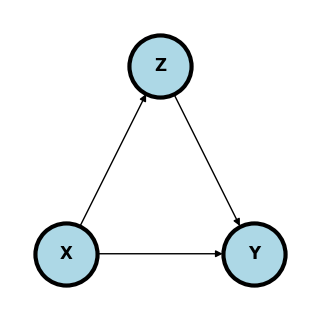

In [9]:
plt.figure(figsize=[3, 3])
G = nx.DiGraph()
G.add_node("X",  pos = (0  ,   0) )
G.add_node("Z",  pos = (0.5,   1) )
G.add_node("Y",  pos =  (1 ,   0) )
G.add_edges_from([
  ["X", "Y"],
  ["X", "Z"],
  ["Z", "Y"],
] )
nx.draw(G,
        nx.get_node_attributes(G, 'pos'),
        with_labels=True,
        font_weight='bold',
        node_size = 2000,
        node_color = "lightblue",
        linewidths = 3)
ax= plt.gca()
ax.collections[0].set_edgecolor("#000000")
ax.set_xlim([-.3, 1.3])
ax.set_ylim([-.3, 1.3])
plt.show()

The backdoor criteria does not apply here, since $Z$ is a descendant of $X$. To answer the question "What is the causal effect of $X$ on $Y$?" one need not adjust. However, mediation is typically studied in a different way. Instead, one asks questions such as "How much of the effect of $X$ on $Y$ flows or doesn't flow through $Z$?". To answer this question, one usually conditions on $Z$ for a different goal than the backdoor adjustment is accomplishing.

@cinelli2021crash shows an interesting example of mediation where one would want to adjust for $Z$ (left plot below).

(-0.3, 1.3)

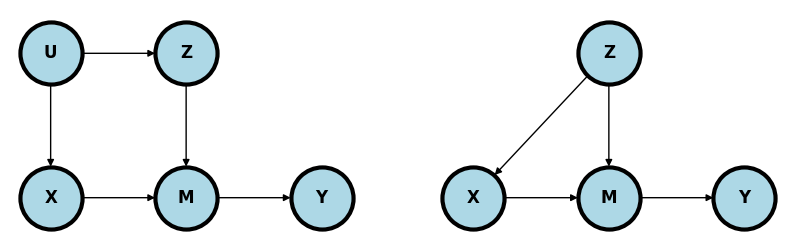

In [10]:
plt.figure(figsize=[10, 3])

plt.subplot(1, 2, 1)
G = nx.DiGraph()
G.add_node("X",  pos = (0  ,   0) )
G.add_node("U",  pos = (0  ,   1) )
G.add_node("Z",  pos = (1,   1) )
G.add_node("M",  pos =  (1 ,   0) )
G.add_node("Y",  pos =  (2 ,   0) )

G.add_edges_from([
  ["U", "X"],
  ["U", "Z"],
  ["X", "M"],
  ["Z", "M"],
  ["M", "Y"]
] )

nx.draw(G,
        nx.get_node_attributes(G, 'pos'),
        with_labels=True,
        font_weight='bold',
        node_size = 2000,
        node_color = "lightblue",
        linewidths = 3)
ax= plt.gca()
ax.collections[0].set_edgecolor("#000000")
ax.set_xlim([-.3, 2.3])
ax.set_ylim([-.3, 1.3])

plt.subplot(1, 2, 2)
G = nx.DiGraph()
G.add_node("X",  pos = (0  ,   0) )
G.add_node("Z",  pos = (1,   1) )
G.add_node("M",  pos =  (1 ,   0) )
G.add_node("Y",  pos =  (2 ,   0) )

G.add_edges_from([
  ["Z", "X"],
  ["X", "M"],
  ["Z", "M"],
  ["M", "Y"]
] )

nx.draw(G,
        nx.get_node_attributes(G, 'pos'),
        with_labels=True,
        font_weight='bold',
        node_size = 2000,
        node_color = "lightblue",
        linewidths = 3)
ax= plt.gca()
ax.collections[0].set_edgecolor("#000000")
ax.set_xlim([-.3, 2.3])
ax.set_ylim([-.3, 1.3])
#plt.show()

In this case, $M$ still mediates the relationship between $X$ and $Y$. However, $Z$ is in a backdoor path to $M$. So, some of the variation in $M$ that impacts $Y$ could be due to $Z$ rather than $X$. The right plot is similar and makes the point more explicit. $Z$ confounds the relationship between $X$ and $Y$ through $M$. Without adjusting for $Z$, the path $X\leftarrow Z \rightarrow M \rightarrow Y$ remains unblocked.

#### Bad controls



The following are all unhelpful for conditioning on $Z$ using the backdoor criteria.

Upper left. Adjusting for colliders is the standard bad control. Below adjusting for $Z$ open ups a backdoor path that was closed. From a common sense perspective, why would you want to adjust for a consequence of $X$ and $Y$ when exploring their relationship?

In the upper right diagram below, $Z$ is a so-called **instrumental** variable. A good example is $Z$ being the randomization indicator and $X$ being the treatment the person actually took. It is important in this example to emphasize that use of the instrumental variable is often a very fruitful method of analysis. However, it's not a useful backdoor adjustment and conditioning on $Z$ simply removes most of the relevant variation in $X$. If one wants to use $Z$ as an instrumental variable in this setting, then specific methods taylored to instrumental variable use need to be employed.

In the lower left plot, $Z$ is a descendant of $X$. Conditioning on $Z$ removes relevant pathway information regarding the relationship between $X$ and $Y$>

The lower right plot is similar. Conditioning on $Z$ removes variation in $M$ which hinders our
ability to study the relationship between $X$ and $Y$ through $M$.

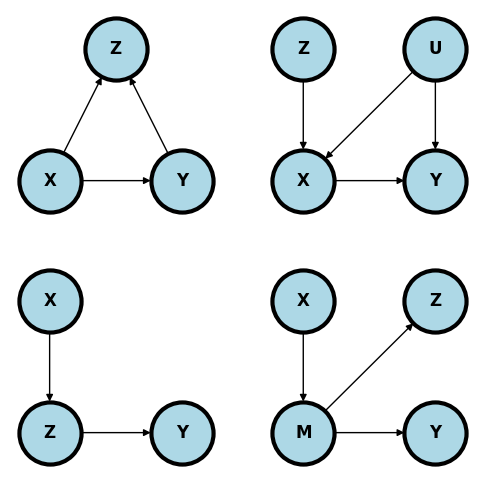

In [11]:
plt.figure(figsize=[6, 6])


#| echo: false
plt.subplot(2, 2, 1)
G = nx.DiGraph()
G.add_node("X",  pos = (0  ,   0) )
G.add_node("Z",  pos = (0.5,   1) )
G.add_node("Y",  pos =  (1 ,   0) )
G.add_edges_from([
  ["X", "Y"],
  ["X", "Z"],
  ["Y", "Z"],
] )
nx.draw(G,
        nx.get_node_attributes(G, 'pos'),
        with_labels=True,
        font_weight='bold',
        node_size = 2000,
        node_color = "lightblue",
        linewidths = 3)
ax= plt.gca()
ax.collections[0].set_edgecolor("#000000")
ax.set_xlim([-.3, 1.3])
ax.set_ylim([-.3, 1.3])

plt.subplot(2, 2, 2)
G = nx.DiGraph()
G.add_node("X",  pos = (0, 0) )
G.add_node("Z",  pos = (0, 1) )
G.add_node("U",  pos = (1, 1) )
G.add_node("Y",  pos = (1, 0) )
G.add_edges_from([
  ["X", "Y"],
  ["U", "X"],
  ["U", "Y"],
  ["Z", "X"]
] )
nx.draw(G,
        nx.get_node_attributes(G, 'pos'),
        with_labels=True,
        font_weight='bold',
        node_size = 2000,
        node_color = "lightblue",
        linewidths = 3)
ax= plt.gca()
ax.collections[0].set_edgecolor("#000000")
ax.set_xlim([-.3, 1.3])
ax.set_ylim([-.3, 1.3])



plt.subplot(2, 2, 3)
G = nx.DiGraph()
G.add_node("Z",  pos = (0, 0) )
G.add_node("X",  pos = (0, 1) )
G.add_node("Y",  pos = (1, 0) )
G.add_edges_from([
  ["X", "Z"],
  ["Z", "Y"]
] )
nx.draw(G,
        nx.get_node_attributes(G, 'pos'),
        with_labels=True,
        font_weight='bold',
        node_size = 2000,
        node_color = "lightblue",
        linewidths = 3)
ax= plt.gca()
ax.collections[0].set_edgecolor("#000000")
ax.set_xlim([-.3, 1.3])
ax.set_ylim([-.3, 1.3])

plt.subplot(2, 2, 4)
G = nx.DiGraph()
G.add_node("X",  pos = (0, 1) )
G.add_node("M",  pos = (0, 0) )
G.add_node("Z",  pos = (1, 1) )
G.add_node("Y",  pos = (1, 0) )
G.add_edges_from([
  ["X", "M"],
  ["M", "Z"],
  ["M", "Y"]
] )
nx.draw(G,
        nx.get_node_attributes(G, 'pos'),
        with_labels=True,
        font_weight='bold',
        node_size = 2000,
        node_color = "lightblue",
        linewidths = 3)
ax= plt.gca()
ax.collections[0].set_edgecolor("#000000")
ax.set_xlim([-.3, 1.3])
ax.set_ylim([-.3, 1.3])


plt.show();

#### Conditioning may help

In the upper left plot, adjusting for $Z$ may reduce variability in $Y$ to help focus on the relationship between $X$ and $Y$.

In the upper left plot, adjusting for $Z$ may reduce variation in the mediator unrelated to the relationship between $X$ and $Y$.


(-0.3, 1.3)

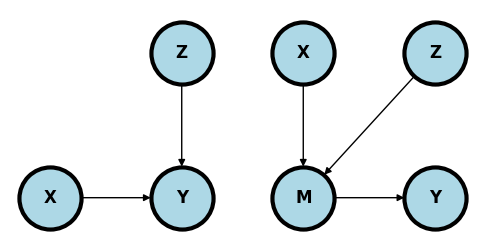

In [12]:
plt.figure(figsize=[6, 3])

plt.subplot(1, 2, 1)
G = nx.DiGraph()
G.add_node("X",  pos = (0, 0) )
G.add_node("Z",  pos = (1, 1) )
G.add_node("Y",  pos = (1, 0) )
G.add_edges_from([
  ["X", "Y"],
  ["Z", "Y"]
] )
nx.draw(G,
        nx.get_node_attributes(G, 'pos'),
        with_labels=True,
        font_weight='bold',
        node_size = 2000,
        node_color = "lightblue",
        linewidths = 3)
ax= plt.gca()
ax.collections[0].set_edgecolor("#000000")
ax.set_xlim([-.3, 1.3])
ax.set_ylim([-.3, 1.3])


plt.subplot(1, 2, 2)
G = nx.DiGraph()
G.add_node("X",  pos = (0, 1) )
G.add_node("M",  pos = (0, 0) )
G.add_node("Z",  pos = (1, 1) )
G.add_node("Y",  pos = (1, 0) )
G.add_edges_from([
  ["X", "M"],
  ["Z", "M"],
  ["M", "Y"]
] )
nx.draw(G,
        nx.get_node_attributes(G, 'pos'),
        with_labels=True,
        font_weight='bold',
        node_size = 2000,
        node_color = "lightblue",
        linewidths = 3)
ax= plt.gca()
ax.collections[0].set_edgecolor("#000000")
ax.set_xlim([-.3, 1.3])
ax.set_ylim([-.3, 1.3])

## Exercises

### Graphs
Consider the following graph where we want to answer the question: what is $P(Y ~|~ do(X) = x)$ where
every variable is binary.

(-0.3, 1.3)

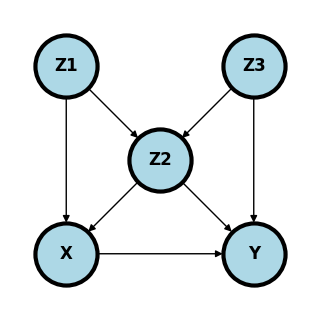

In [13]:
plt.figure(figsize=[3, 3])
G = nx.DiGraph()
G.add_node("X",   pos = (0, 0) )
G.add_node("Z1",  pos = (0, 1) )
G.add_node("Z2",  pos = (0.5, 0.5) )
G.add_node("Z3",  pos = (1, 1) )
G.add_node("Y",  pos = (1, 0) )
G.add_edges_from([
  ["X", "Y"],
  ["Z2", "X"],
  ["Z1", "X"],
  ["Z1", "Z2"],
  ["Z3", "Y"],
  ["Z3", "Z2"],
  ["Z2", "Y"]
] )
nx.draw(G,
        nx.get_node_attributes(G, 'pos'),
        with_labels=True,
        font_weight='bold',
        node_size = 2000,
        node_color = "lightblue",
        linewidths = 3)
ax= plt.gca()
ax.collections[0].set_edgecolor("#000000")
ax.set_xlim([-.3, 1.3])
ax.set_ylim([-.3, 1.3])

1. What are the minimal set of adjustment variables for the backdoor criteria?
2. Is $X \perp Y ~|~ Z_1, Z_2$?
3. Is $X \perp Y ~|~ Z_2, Z_3$?
4. Given a cross sectional sample, if $Z_3$ is unobserved, give a formula for the estimation of $P(Y ~|~ do(X) = x)$ that only requires observed variables.

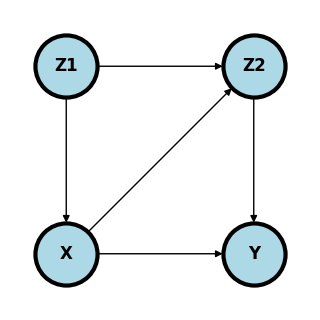

In [14]:
#| echo: false
plt.figure(figsize=[3, 3])
G = nx.DiGraph()
G.add_node("X",   pos = (0, 0) )
G.add_node("Z1",  pos = (0, 1) )
G.add_node("Z2",  pos = (1, 1) )
G.add_node("Y",  pos = (1, 0) )
G.add_edges_from([
  ["X", "Y"],
  ["X", "Z2"],
  ["Z1", "X"],
  ["Z1", "Z2"],
  ["Z2", "Y"]
] )
nx.draw(G,
        nx.get_node_attributes(G, 'pos'),
        with_labels=True,
        font_weight='bold',
        node_size = 2000,
        node_color = "lightblue",
        linewidths = 3)
ax= plt.gca()
ax.collections[0].set_edgecolor("#000000")
ax.set_xlim([-.3, 1.3])
ax.set_ylim([-.3, 1.3]);

1. What are the minimal set of adjustment variables for the backdoor criteria?
2. Given a cross sectional sample, give a formula for the estimation of $P(Y ~|~ do(X) = x)$ that only requires observed variables.

### Data exercise

The wikipedia page on Simpson's paradox gives this data concerning two treatments of kidney stones, the percentage of succcessful procedures and the size of the stone. Note, among both large stones and small stones A is better than B. However, among all B is preferable to A.

| Size | Treatment | Success | N       | Prop |
|------|-----------|---------|---------|------|
| Large| A         | 192     | 263     | 73%  |
|      | B         | 55      | 80      | 69%  |
| Small| A         | 81      | 87      | 93%  |
|      | B         | 234     | 270     | 87%  |
| Both | A         | 273     | 350     | 78%  |
|      | B         | 289     | 350     | 83%  |

Estimate the treatment effect difference:
$$
P(Success ~|~ Do(Treatment) = B)
- P(Success ~|~ Do(Treatment) = A)
$$
under the following graphical models where $X$ is treatment, $Y$ is success and $Z$ is stone size:


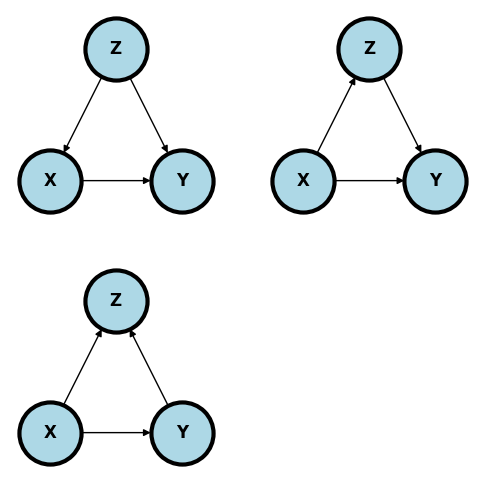

In [15]:
plt.figure(figsize=[6, 6])


#| echo: false
plt.subplot(2, 2, 1)
G = nx.DiGraph()
G.add_node("X",  pos = (0  ,   0) )
G.add_node("Z",  pos = (0.5,   1) )
G.add_node("Y",  pos =  (1 ,   0) )
G.add_edges_from([
  ["X", "Y"],
  ["Z", "X"],
  ["Z", "Y"],
] )
nx.draw(G,
        nx.get_node_attributes(G, 'pos'),
        with_labels=True,
        font_weight='bold',
        node_size = 2000,
        node_color = "lightblue",
        linewidths = 3)
ax= plt.gca()
ax.collections[0].set_edgecolor("#000000")
ax.set_xlim([-.3, 1.3])
ax.set_ylim([-.3, 1.3])

plt.subplot(2, 2, 2)
G = nx.DiGraph()
G.add_node("X",  pos = (0  ,   0) )
G.add_node("Z",  pos = (0.5,   1) )
G.add_node("Y",  pos =  (1 ,   0) )
G.add_edges_from([
  ["X", "Y"],
  ["X", "Z"],
  ["Z", "Y"],
] )
nx.draw(G,
        nx.get_node_attributes(G, 'pos'),
        with_labels=True,
        font_weight='bold',
        node_size = 2000,
        node_color = "lightblue",
        linewidths = 3)
ax= plt.gca()
ax.collections[0].set_edgecolor("#000000")
ax.set_xlim([-.3, 1.3])
ax.set_ylim([-.3, 1.3])

plt.subplot(2, 2, 3)
G = nx.DiGraph()
G.add_node("X",  pos = (0  ,   0) )
G.add_node("Z",  pos = (0.5,   1) )
G.add_node("Y",  pos =  (1 ,   0) )
G.add_edges_from([
  ["X", "Y"],
  ["X", "Z"],
  ["Y", "Z"],
] )
nx.draw(G,
        nx.get_node_attributes(G, 'pos'),
        with_labels=True,
        font_weight='bold',
        node_size = 2000,
        node_color = "lightblue",
        linewidths = 3)
ax= plt.gca()
ax.collections[0].set_edgecolor("#000000")
ax.set_xlim([-.3, 1.3])
ax.set_ylim([-.3, 1.3])


plt.show();

Comment on how reasonable each of these models are given the setting. Here's a reference: @julious1994confounding.

Give any other DAGs, perhaps including unmeasured variables, that you think are relevant.



## Reading
+ The definitive causal reference is @pearl2009causality.
+ I got a lot of this stuff from @peters2017elements, which you can read [here](https://library.oapen.org/bitstream/id/056a11be-ce3a-44b9-8987-a6c68fce8d9b/11283.pdf)
+ Also read @hardt2021patterns, which you can read [here](https://mlstory.org/index.html)
+ [A crash course in good and bad controls](https://ftp.cs.ucla.edu/pub/stat_ser/r493.pdf), or [here](http://causality.cs.ucla.edu/blog/index.php/category/back-door-criterion/)
+ [dagitty](http://dagitty.net/.html#)